In [1]:
import fatbox

In [2]:
import numpy as np 
import networkx as nx
import pickle
import cv2
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
from scipy.spatial import distance_matrix
from skimage import feature, morphology, filters
from sklearn.preprocessing import normalize

from sys import stdout

from fatbox.preprocessing import *
from fatbox.metrics import *
from fatbox.edits import *
from fatbox.plots import *

In [33]:
img = Image.open(r'D:\PYTHON\fatbox\fatbox_tutorials\Predicted_fault_data\Kerry_inline_14.png').convert('L')
data = np.array(img)

data = 1-(data-np.min(data))/(np.max(data)-np.min(data))

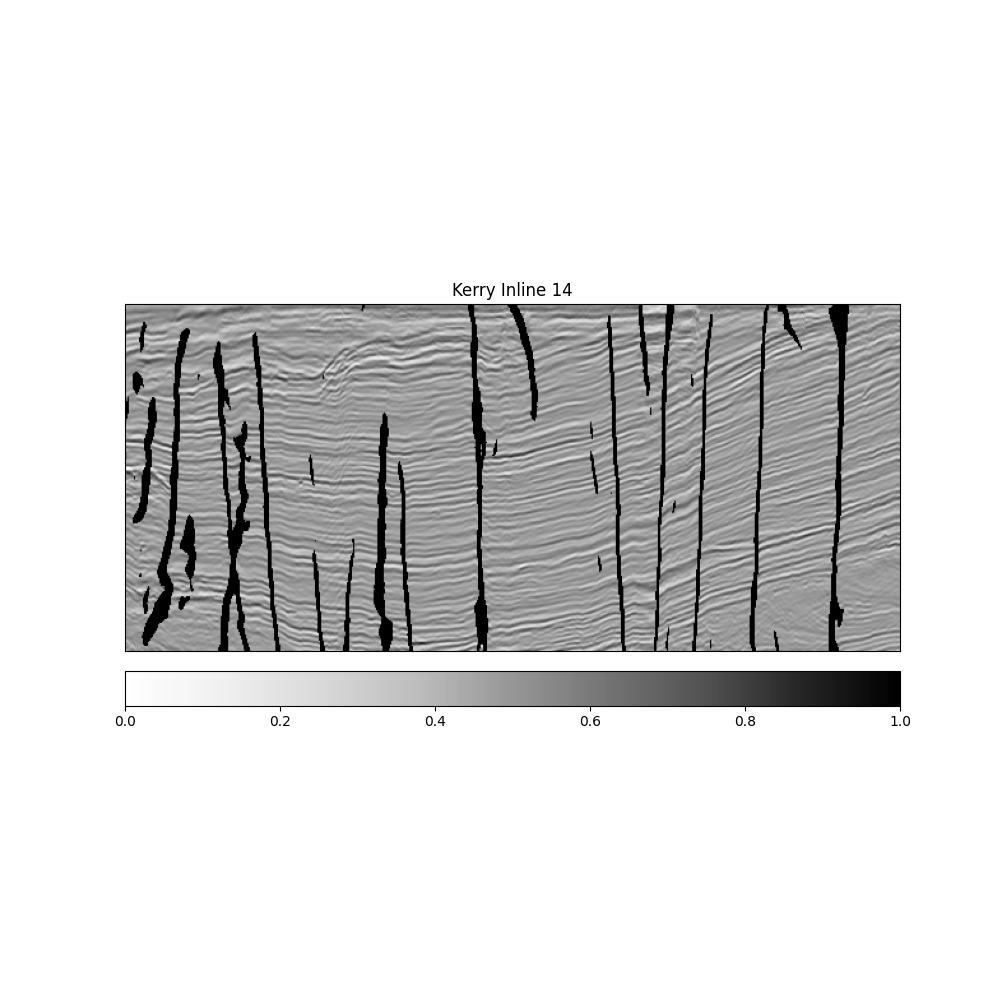

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(data, cmap='Greys', vmin=0)
plt.xticks([])
plt.yticks([])
plt.title('Kerry Inline 14')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="10%", pad=0.2, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.savefig('./Kerry Inline 14.png')
plt.show()


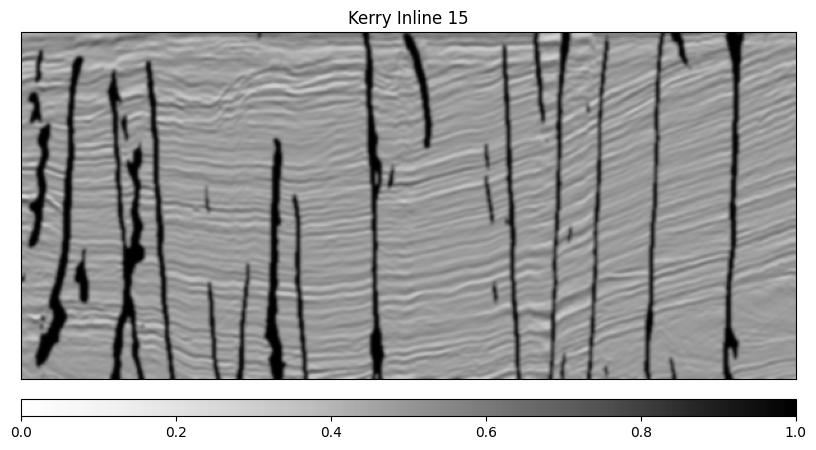

In [6]:
smoothed = filters.gaussian(data, sigma=1.2)

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(smoothed, cmap='Greys', vmin=0)
plt.xticks([])
plt.yticks([])
plt.title('Kerry Inline 15')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.2, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.show()

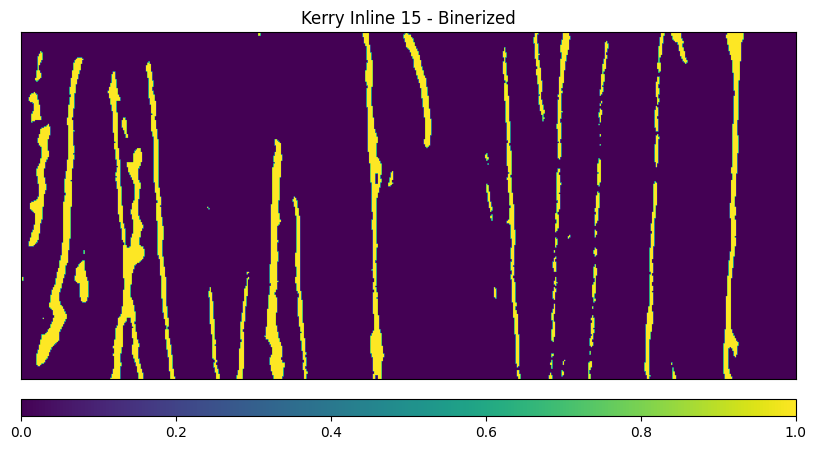

In [7]:
threshold = simple_threshold_binary(smoothed, 0.8)

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(threshold, vmin=0, vmax=1)
plt.xticks([])
plt.yticks([])
plt.title('Kerry Inline 15 - Binerized')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.2, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.savefig('./Kerry Inline 15 - Binerized.png')
plt.show()


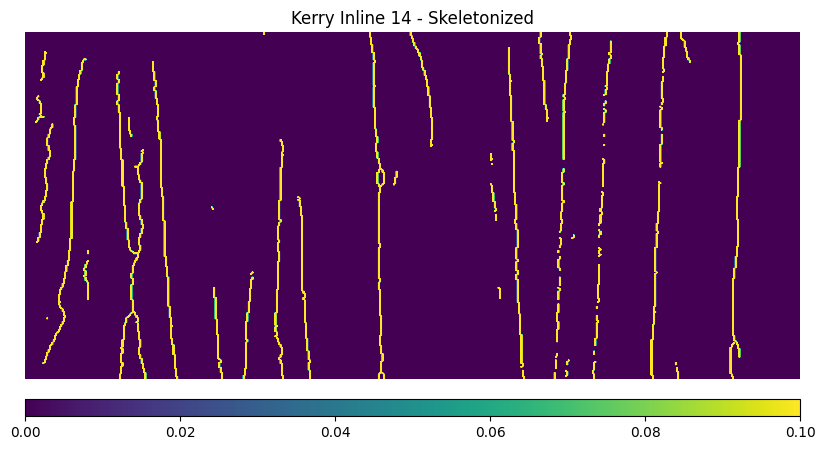

<class 'numpy.ndarray'>


<Figure size 640x480 with 0 Axes>

In [8]:
skeleton = skeleton_guo_hall(threshold)

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(skeleton, vmin=0, vmax=0.1)
plt.axis('off')
plt.title('Kerry Inline 14 - Skeletonized')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.2, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.show()
plt.savefig('./Kerry Inline 15 - Skeletonized.png')
print(type(skeleton))

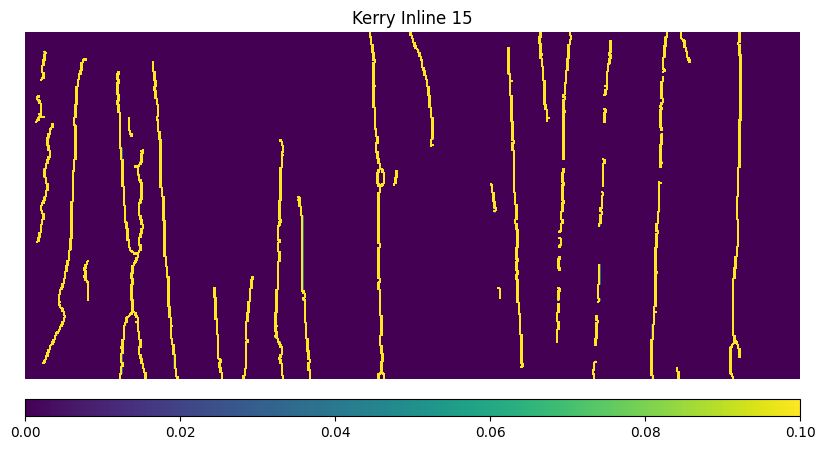

In [9]:
skeleton = remove_small_regions((skeleton), 8)
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(skeleton, vmin=0, vmax=0.1)
plt.axis('off')
plt.title('Kerry Inline 15')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.2, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.savefig('./Kerry Inline 14 - Removed Small Area.png')
plt.show()

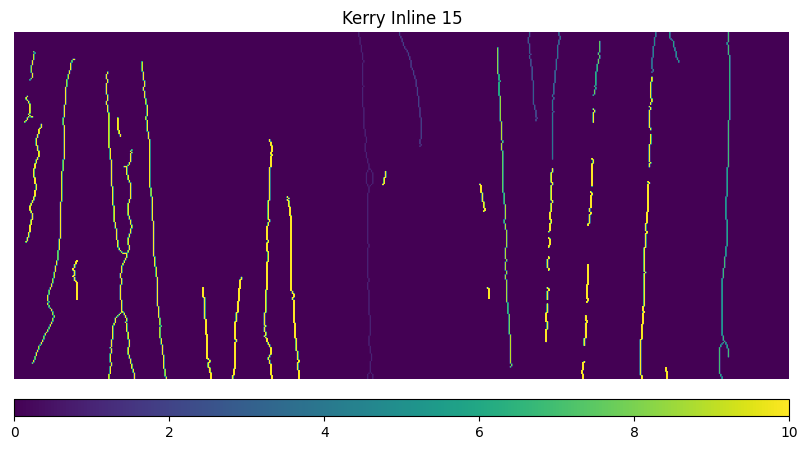

In [10]:

ret, markers = cv2.connectedComponents(skeleton, connectivity=8)

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(markers, vmin=0, vmax=10)
plt.axis('off')
plt.title('Kerry Inline 15')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.2, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.savefig('./Kerry Inline 15 - Connected Components.png')
plt.show()
     

In [11]:
G = nx.Graph()

node = 0
for comp in tqdm(range(1,ret)):

    points = np.transpose(np.vstack((np.where(markers==comp))))    
    
    for point in points:
        G.add_node(node)
        G.nodes[node]['pos'] = (point[1], point[0])
        G.nodes[node]['component'] = comp
        node += 1  

100%|██████████| 40/40 [00:00<00:00, 919.91it/s]


In [12]:
for comp in tqdm(range(1,ret)): 
    
    points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
    nodes  = [node for node in G if G.nodes[node]['component']==comp]

    dm = distance_matrix(points, points)  
    
    
    for n in range(len(points)):
        # print(n)
        for m in range(len(points)):
            if dm[n,m]<1.5 and n != m:
                G.add_edge(nodes[n],nodes[m])

100%|██████████| 40/40 [00:00<00:00, 139.10it/s]


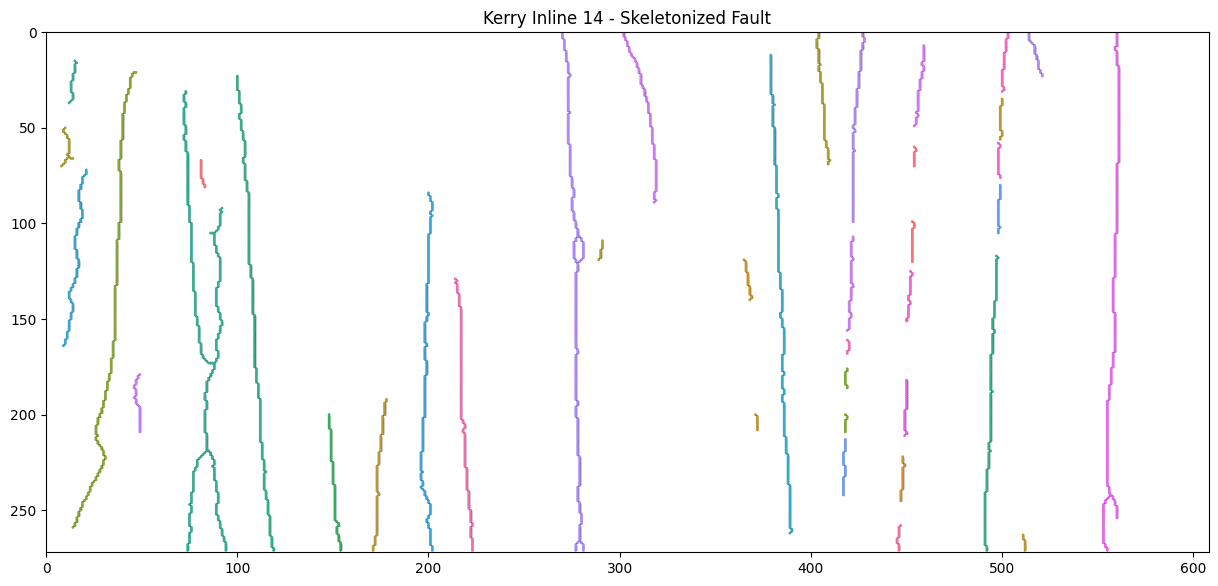

In [13]:
G = label_components(G)

fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.imshow(np.zeros_like(data), 'gray_r', vmin=0)
plt.title('Kerry Inline 14 - Skeletonized Fault')
plot_components(G, label=False, node_size=1, ax=ax)
# plot_faults(G, label=True, node_size=1, ax=ax)
ax.set_xlim(0,data.shape[1])
ax.set_ylim(data.shape[0],0)
plt.show()

In [14]:
G = split_triple_junctions(G, 25)
G = label_components(G)

In [16]:
removed = [1, 34, 50, 17, 3, 45, 25]
for i in removed:
    G = remove_component(G, i)

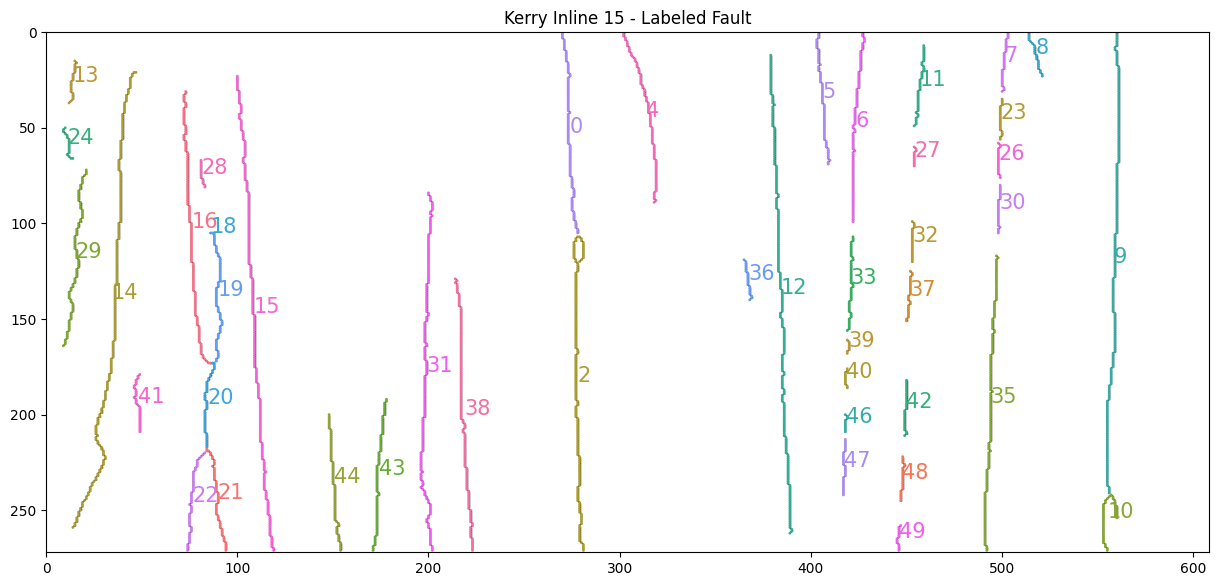

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.imshow(np.zeros_like(data), 'gray_r', vmin=0)
plot_components(G, label=True, node_size=1, ax=ax)
plt.title('Kerry Inline 15 - Labeled Fault')
ax.axis('on')
ax.set_xlim(0,data.shape[1])
ax.set_ylim(data.shape[0],0)
plt.savefig('./Kerry Inline 15 - Labeled Predicted Fault.png')
plt.show()


In [18]:
G = label_components(G)
G = compute_edge_length(G)
G = calculate_strike(G, 3)
G = comp_to_fault(G)
# H = expand_network(G)

Calculate strike: 100%|██████████| 3179/3179 [00:00<00:00, 64829.26it/s]


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24440\1484380427.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('Oranges_r', 128) # r means reversed version
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24440\1484380427.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap('Blues', 128)# combine it all


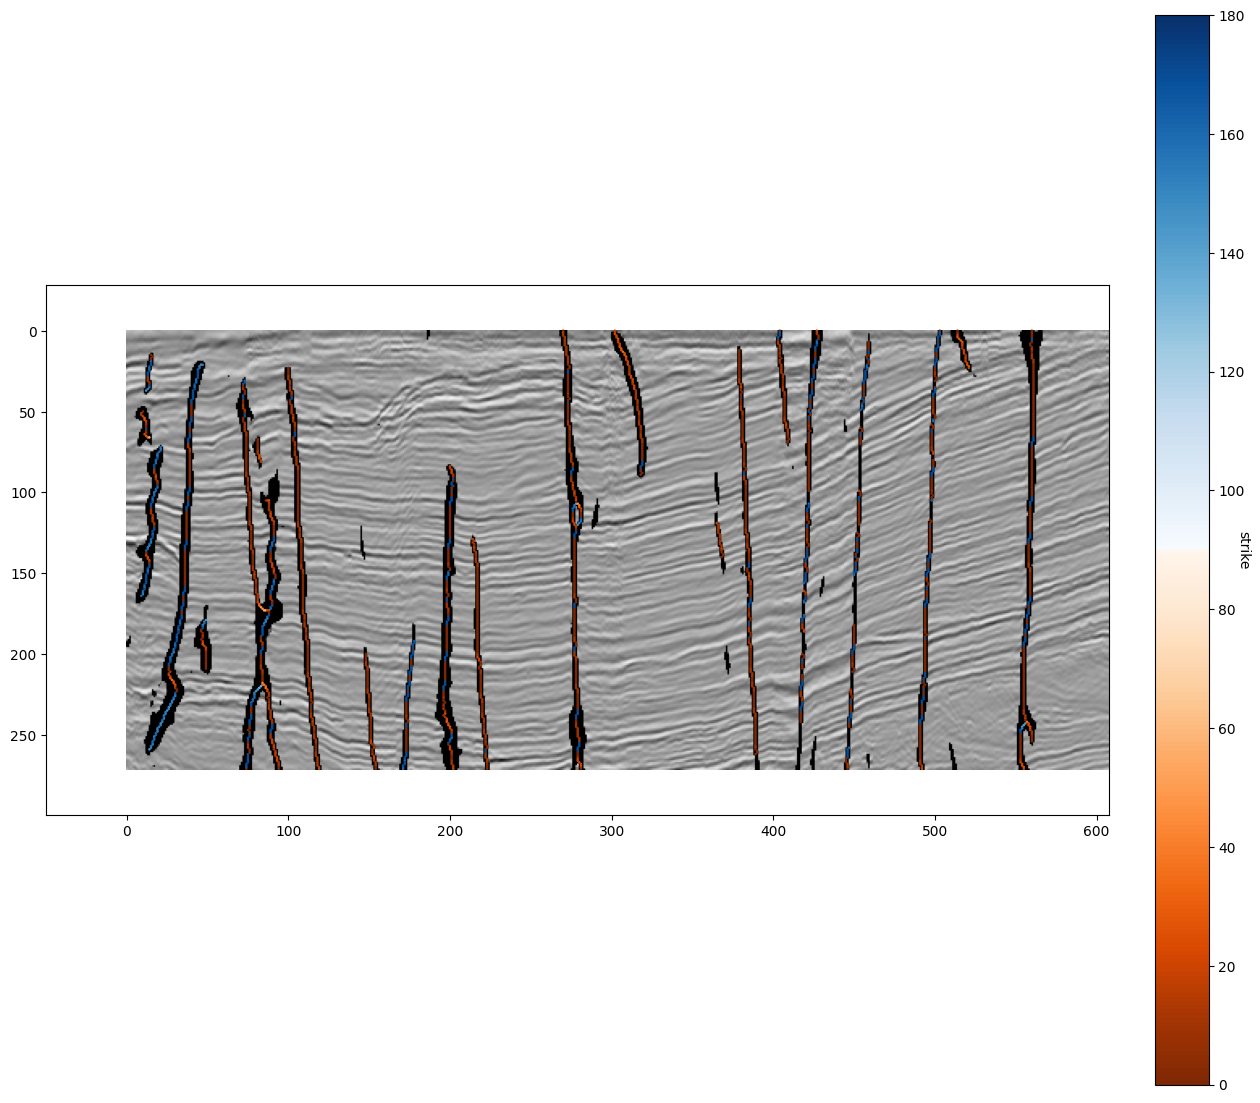

In [19]:
top = cm.get_cmap('Oranges_r', 128) # r means reversed version
bottom = cm.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = ListedColormap(newcolors, name='OrangeBlue')


fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(data, cmap='Greys', vmin=0, vmax=1)
plot_attribute(G, 'strike', cmap = orange_blue, vmin=0, vmax=180, ax=ax)
plt.show()

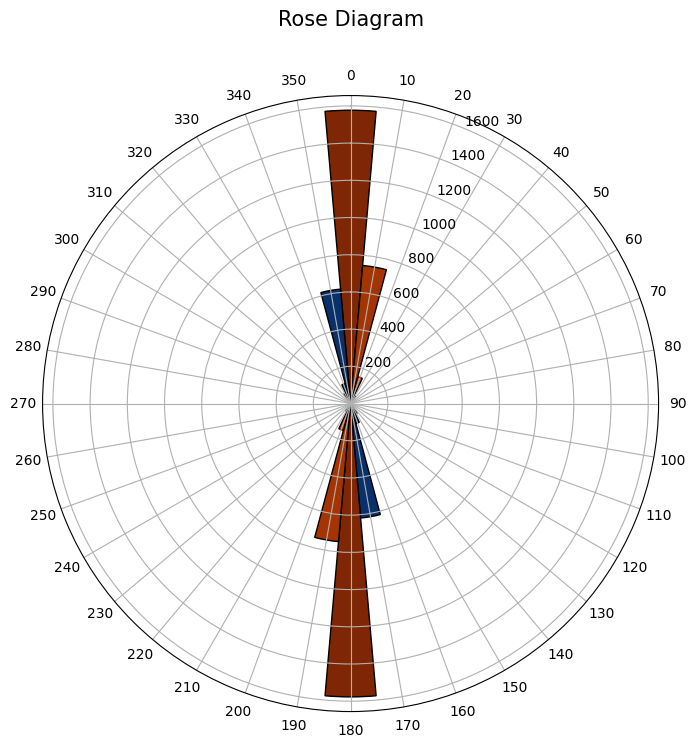

In [20]:
plot_rose(G)

In [22]:
import networkx as nx; 
from networkx.readwrite import json_graph;

In [24]:
import json
json_G = json_graph.node_link_data(G)
json_G

{'directed': False,
 'multigraph': False,
 'graph': {},
 'nodes': [{'pos': (270, 0),
   'component': 0,
   'strike': 0.0,
   'fault': 0,
   'id': 0},
  {'pos': (270, 1),
   'component': 0,
   'strike': 14.036243467926479,
   'fault': 0,
   'id': 1},
  {'pos': (270, 2),
   'component': 0,
   'strike': 11.309932474020213,
   'fault': 0,
   'id': 2},
  {'pos': (270, 3),
   'component': 0,
   'strike': 9.462322208025617,
   'fault': 0,
   'id': 3},
  {'pos': (271, 4),
   'component': 0,
   'strike': 9.462322208025617,
   'fault': 0,
   'id': 4},
  {'pos': (271, 5),
   'component': 0,
   'strike': 9.462322208025617,
   'fault': 0,
   'id': 5},
  {'pos': (271, 6),
   'component': 0,
   'strike': 9.462322208025617,
   'fault': 0,
   'id': 6},
  {'pos': (271, 7),
   'component': 0,
   'strike': 9.462322208025617,
   'fault': 0,
   'id': 7},
  {'pos': (271, 8),
   'component': 0,
   'strike': 9.462322208025617,
   'fault': 0,
   'id': 8},
  {'pos': (271, 9),
   'component': 0,
   'strike': 9.46

In [26]:
G_3d_15 = G

node = 0
for comp in tqdm(range(1,ret)):

    points = np.transpose(np.vstack((np.where(markers==comp))))    
    
    for point in points:
        G_3d_15.add_node(node)
        G_3d_15.nodes[node]['pos'] = (15, point[1], point[0])
        G_3d_15.nodes[node]['component'] = comp
        node += 1  

json_G_3d_15 = json_graph.node_link_data(G_3d_15)
# json_G_3d

100%|██████████| 40/40 [00:00<00:00, 1052.60it/s]


# Plot 3D

In [27]:
from mpl_toolkits.mplot3d import Axes3D
from chart_studio import plotly
import plotly.offline as pyoff
import plotly.graph_objs as go

In [28]:
(json_G_3d_15).keys()

dict_keys(['directed', 'multigraph', 'graph', 'nodes', 'links'])

In [29]:
node_color, palette = get_node_colors(G_3d_15, 'component', return_palette=True)
pos = nx.get_node_attributes(G_3d_15, 'pos')

xi, yi, zi, c, s = [], [], [], [], []

for key, value in pos.items():
    xi.append(value[0])
    yi.append(value[1])
    zi.append(value[2])
    # print(type(colors[value]))
    # c.append(colors[key])
    s.append(20+20*G_3d_15.degree(key))

xi, yi, zi = np.array(xi), np.array(yi), np.array(zi)

In [30]:
len(xi), len(yi), len(zi)

(3232, 3232, 3232)

In [ ]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection="3d")

# for i in range(len(xi)):
#     ax.plot3D([xi[i],xi[i+1]], [yi[i], yi[i+1]],[-1*zi[i], -1*zi[i+1]], 'blue', alpha=1)

ax.scatter(xi, yi,-1*zi, marker='o', c=node_color, edgecolors='w', alpha=0.5)
# Axes3D.plot(xs=xi, ys = yi, zs=-1*zi, c='black', alpha=0.5)
plt.show()

In [49]:
def network_plot_3D(G, angle, save=False):

    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # Get number of nodes
    n = G.number_of_nodes()

    # Get the maximum number of edges adjacent to a single node
    edge_max = max([G.degree(i) for i in range(n)])

    # Define color range proportional to number of edges adjacent to a single node
    colors = [plt.cm.plasma(G.degree(i)/edge_max) for i in range(n)] 

    # 3D network plot
    with plt.style.context(('ggplot')):
        
        fig = plt.figure(figsize=(10,7))
        ax = Axes3D(fig)
        
        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        for key, value in pos.items():
            xi = value[0]
            yi = value[1]
            zi = value[2]
            
        # Scatter plot
            ax.scatter(xi, yi, zi, c=colors[key], s=20+20*G.degree(key), edgecolors='k', alpha=0.7)
        
        # Loop on the list of edges to get the x,y,z, coordinates of the connected nodes
        # Those two points are the extrema of the line to be plotted
        for i,j in enumerate(G.edges()):

            x = np.array((pos[j[0]][0], pos[j[1]][0]))
            y = np.array((pos[j[0]][1], pos[j[1]][1]))
            z = np.array((pos[j[0]][2], pos[j[1]][2]))
        
        # Plot the connecting lines
            ax.plot(x, y, z, c='black', alpha=0.5)
    
    # Set the initial view
    ax.view_init(30, angle)

    # Hide the axes
    ax.set_axis_off()

    if save is not False:
        print('a')
        # plt.savefig(f""C:\scratch\\data\"+str{angle}.zfill{3}+".png"")
        # plt.close('all')
    else:
        plt.show()
    
    return